In [18]:
from transformers import T5ForConditionalGeneration, T5Tokenizer

model_name = "t5-small"
model_t5 = T5ForConditionalGeneration.from_pretrained(model_name)
tokenizer_t5 = T5Tokenizer.from_pretrained(model_name)

def infer_t5(input_text, command="translate to french"):
    prompt = f"{command}: {input_text}"
    input_ids = tokenizer_t5.encode(prompt, return_tensors="pt")
    output_ids = model_t5.generate(input_ids, max_new_tokens=1000)
    output_text = tokenizer_t5.decode(output_ids[0], skip_special_tokens=True)
    return output_text


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [6]:
from transformers import MarianMTModel, MarianTokenizer

model_name = "Helsinki-NLP/opus-mt-en-roa"
tokenizer_marian = MarianTokenizer.from_pretrained(model_name)
model_marian = MarianMTModel.from_pretrained(model_name)

def infer_marian(input_text, command="translate to french"):
    src_text = [f">>fra<<{input_text}"]
    output_ids = model_marian.generate(**tokenizer_marian(src_text, return_tensors="pt", padding=True))
    output_text = tokenizer_marian.decode(output_ids[0], skip_special_tokens=True)
    return output_text


In [7]:
from transformers import MBartForConditionalGeneration, MBart50TokenizerFast

model_name = 'facebook/mbart-large-50-many-to-many-mmt'
model_mbart = MBartForConditionalGeneration.from_pretrained(model_name)
tokenizer_mbart = MBart50TokenizerFast.from_pretrained(model_name)

def infer_mbart(input_text, command="translate to french"):
    tokenizer_mbart.src_lang = "en_XX"
    encoded_hi = tokenizer_mbart(input_text, return_tensors="pt")
    generated_tokens = model_mbart.generate(
        **encoded_hi,
        forced_bos_token_id=tokenizer_mbart.lang_code_to_id["fr_XX"]
    )
    return tokenizer_mbart.batch_decode(generated_tokens, skip_special_tokens=True)[0]

In [3]:
import requests 
import pandas as pd

dataset = [] 
for index in range(0, 1000, 100):
    url = f"https://datasets-server.huggingface.co/rows?dataset=giga_fren&config=en-fr&split=train&offset={index}&length=100"
    response = requests.get(url)
    data = response.json()
    for row in data["rows"]:
        x = row["row"]["translation"]["en"]
        y = row["row"]["translation"]["fr"]
        dataset.append((x, y))
    print(f"Downloaded {index + 100} rows")
df = pd.DataFrame(dataset, columns=["input_text", "target_text"])
df.head()
df.to_csv("giga_fren.csv", index=False)

Downloaded 100 rows
Downloaded 200 rows
Downloaded 300 rows
Downloaded 400 rows
Downloaded 500 rows
Downloaded 600 rows
Downloaded 700 rows
Downloaded 800 rows
Downloaded 900 rows
Downloaded 1000 rows


In [37]:
df = pd.read_csv("giga_fren.csv")

for index, row in df.iterrows():
    df.loc[index, "t5"] = infer_t5(row["input_text"])
    if index % 100 == 0:
        print(f"Translated {index} rows for t5")      

df.head()

Translated 0 rows for t5
Translated 100 rows for t5
Translated 200 rows for t5
Translated 300 rows for t5
Translated 400 rows for t5
Translated 500 rows for t5
Translated 600 rows for t5
Translated 700 rows for t5
Translated 800 rows for t5
Translated 900 rows for t5


,input_text,target_text,t5
0,Changing Lives _BAR_ Changing Society _BAR_ Ho...,Il a transformé notre vie _BAR_ Il a transform...,Changing Lives _BAR_ Changing Society _BAR_ Ho...
1,Site map,Plan du site,Plan du site
2,Feedback,Rétroaction,Commentaires
3,Credits,Crédits,Crédits
4,Français,English,Français


In [38]:
for index, row in df.iterrows():
    df.loc[index, "marian"] = infer_marian(row["input_text"])
    if index % 100 == 0:
        print(f"Translated {index} rows for marian")

df.head()

Translated 0 rows for marian
Translated 100 rows for marian
Translated 200 rows for marian
Translated 300 rows for marian
Translated 400 rows for marian
Translated 500 rows for marian
Translated 600 rows for marian
Translated 700 rows for marian
Translated 800 rows for marian
Translated 900 rows for marian


,input_text,target_text,t5,marian
0,Changing Lives _BAR_ Changing Society _BAR_ Ho...,Il a transformé notre vie _BAR_ Il a transform...,Changing Lives _BAR_ Changing Society _BAR_ Ho...,Changement de vie _BAR_ Changement de société ...
1,Site map,Plan du site,Plan du site,Carte du site
2,Feedback,Rétroaction,Commentaires,Rétroactions
3,Credits,Crédits,Crédits,Crédits
4,Français,English,Français,English


In [39]:
for index, row in df.iterrows():
    df.loc[index, "mbart"] = infer_mbart(row["input_text"])
    if index % 100 == 0:
        print(f"Translated {index} rows for mbart")
    
df.head()

Translated 0 rows for mbart


KeyboardInterrupt: 

In [40]:
df.to_csv("giga_fren_translated.csv", index=False)
df = pd.read_csv("giga_fren_translated.csv")
df.head()

,input_text,target_text,t5,marian,mbart
0,Changing Lives _BAR_ Changing Society _BAR_ Ho...,Il a transformé notre vie _BAR_ Il a transform...,Changing Lives _BAR_ Changing Society _BAR_ Ho...,Changement de vie _BAR_ Changement de société ...,Changing Lives _BAR_ Changing Society _BAR_ Ho...
1,Site map,Plan du site,Plan du site,Carte du site,Carte du site
2,Feedback,Rétroaction,Commentaires,Rétroactions,Rétroaction
3,Credits,Crédits,Crédits,Crédits,Crédits
4,Français,English,Français,English,English (en anglais seulement)


In [49]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

def calculate_bleu(reference, candidate):
    return corpus_bleu([[reference]], [candidate], smoothing_function=SmoothingFunction().method1)
df["bleu_t5"] = df.apply(lambda i: calculate_bleu(i["target_text"], i["t5"]), axis=1,)
df["bleu_marian"] = df.apply(lambda i: calculate_bleu(i["target_text"], i["marian"]), axis=1)
# df["bleu_mbart"] = df.apply(lambda x: calculate_bleu(x["target_text"], x["mbart"]), axis=1)
df.head()

,input_text,target_text,t5,marian,mbart,bleu_t5,bleu_marian
0,Changing Lives _BAR_ Changing Society _BAR_ Ho...,Il a transformé notre vie _BAR_ Il a transform...,Changing Lives _BAR_ Changing Society _BAR_ Ho...,Changement de vie _BAR_ Changement de société ...,Changing Lives _BAR_ Changing Society _BAR_ Ho...,0.454065,0.674687
1,Site map,Plan du site,Plan du site,Carte du site,Carte du site,1.000000,0.576084
2,Feedback,Rétroaction,Commentaires,Rétroactions,Rétroaction,0.026658,0.903602
3,Credits,Crédits,Crédits,Crédits,Crédits,1.000000,1.000000
4,Français,English,Français,English,English (en anglais seulement),0.065006,1.000000


In [50]:
# calculate average bleu score higher is better
print(f"Average BLEU score for T5: {df['bleu_t5'].mean()}")
print(f"Average BLEU score for Marian: {df['bleu_marian'].mean()}")
# print(f"Average BLEU score for MBart: {df['bleu_mbart'].mean()}")

# calculate median bleu score higher is better
print(f"Median BLEU score for T5: {df['bleu_t5'].median()}")
print(f"Median BLEU score for Marian: {df['bleu_marian'].median()}")
# print(f"Median BLEU score for MBart: {df['bleu_mbart'].median()}")

# calculate standard deviation lower is better
print(f"Standard deviation for T5: {df['bleu_t5'].std()}")
print(f"Standard deviation for Marian: {df['bleu_marian'].std()}")
# print(f"Standard deviation for MBart: {df['bleu_mbart'].std()}")

# calculate variance lower is better
print(f"Variance for T5: {df['bleu_t5'].var()}")
print(f"Variance for Marian: {df['bleu_marian'].var()}")
# print(f"Variance for MBart: {df['bleu_mbart'].var()}")

Average BLEU score for T5: 0.6855164935960816
Average BLEU score for Marian: 0.6906491376640956
Median BLEU score for T5: 0.7000804895239849
Median BLEU score for Marian: 0.7034343502197589
Standard deviation for T5: 0.1527190202690941
Standard deviation for Marian: 0.1486759983530563
Variance for T5: 0.023323099151951972
Variance for Marian: 0.022104552486278004


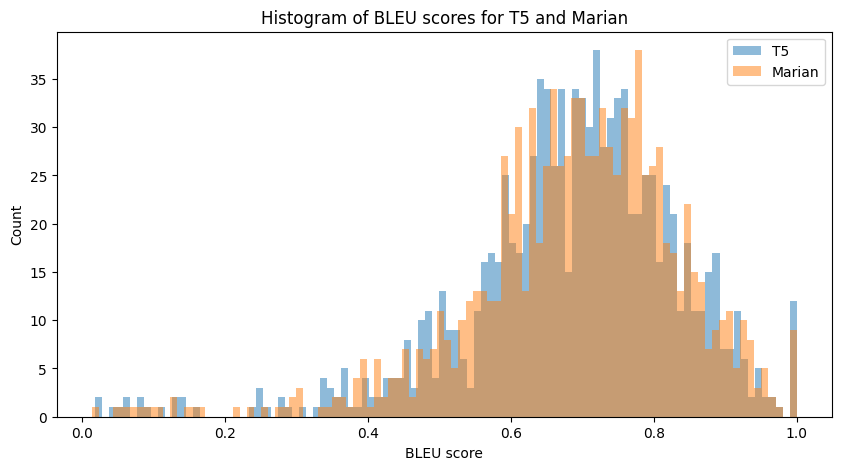

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.hist(df["bleu_t5"], bins=100, alpha=0.5, label="T5")
plt.hist(df["bleu_marian"], bins=100, alpha=0.5, label="Marian")
# plt.hist(df["bleu_mbart"], bins=100, alpha=0.5, label="MBart")
plt.legend()
plt.title("Histogram of BLEU scores for T5 and Marian")
plt.xlabel("BLEU score")
plt.ylabel("Count")
plt.show()